# _Working with different kinds of ‘text’ in the Digital Humanities_
## Singapore University of Technology and Design, 18-19 March, 2019
## Introduction to NLP: From Counting to Lanugage Models

Welcome to From Counting to Lanugage Models!
This is a hands-on workshop focusing on various foundation techniques for Natural Language Processing and their applications in Digital Humanities nad beyond. It anything, it's a methods workshop more than a critical or theoretical workshop: the emphasis is put on the how rathen than the why or what for.

<!--
The workshop will be split into 4 sections with 10 minute breaks in-between. The sections get incrementally more advanced, building on concepts and methods from the previous sections.
-->


To follow along, you can run the script portions piecemeal, in order, as we progress through the workshop material. Up to you. Familiarity with programming concepts and Python is required; Numpy and Jupyter desirable.

Instructor:


<figure>
    <img src="http://postdata.linhd.uned.es/wp-content/uploads/2019/02/javierweb.jpg"
         alt="Javier's picture">
    <figcaption>
        <div align="center">
        <strong>Javier de la Rosa</strong>
        <br/>
        <em>versae@linhd.uned.es</em>, <em><a href="https://twitter.com/versae">@versae</a></em>
        <br/>
        NLP Postdoctoral Fellow at <a href="http://postdata.linhd.uned.es/">UNED's POSTADA Project</a>
       </div>
    </figcaption>
</figure>


## What are we covering today?
- What is NLP
- NLP in Python
- Tokenization
- Part of Speech Tagging
- Named Entity Recognition and Relation Detection
- Word transformations
- Keywords in context
- Counting
- TF-IDF and Document-Term Matrices
- Topic Models
- Clustering and PCA
- ~~Word-word matrices~~
- ~~Word embeddings~~
- ~~Language models~~

Use cases:
- Readability indices
- Corpus level statistics

## NLP in Python

Python is builtin with a very mature regular expression library, which is the building block of natural language processing. However, more advanced tasks need different libraries. Traditionally, in the Python ecosystem the Natural Language Processing Toolkit, abbreviated as `NLTK`, has been until recently the only working choice. Unfortunately, the library has not aged well, and even though it's updated to work with the newer versions of Python, it does not provide us the speed we might need to process large corpora, as its intended use is merely educational.

Another solution that appeared recently is called `spaCy`, and it is much faster since is written in a pseudo-C Python language optimized for speed called Cython. See the [documentation](https://spacy.io/usage/models) for details.

Both these libraries are complex and therefore there exist wrappers around them to simplify their APIs. The two more popular are `Textblob` for NLTK and CLiPS Parser, and `textacy` for spaCy.  In this workshop we will be using spaCy with a touch of textacy thrown in at the very end.

In [1]:
%%capture --no-stderr
import sys
!pip install Cython
!pip install spacy nltk textacy textblob requests matplotlib scikit-learn
!python -m spacy download en
!python -m spacy download es
!python -m nltk.downloader all
print("All done!", file=sys.stderr)

All done!


In [2]:
%matplotlib inline

In [3]:
import spacy

Let's load the English data for now. Support for other [languages is available as well](https://spacy.io/usage/models), although some features might not work. 

In [4]:
nlp = spacy.load('en')

We're also going to need a couple of helper functions to retrieve some texts from US presidents' State of the Union speeches.

In [5]:
# helper functions
import requests

def get_text(url):
    return requests.get(url).text

def get_speech(url):
    page = get_text(url)
    full_text = page.split('\n')
    return " ".join(full_text[2:])

In [6]:
clinton_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/clinton2000.txt"
clinton_speech = get_speech(clinton_url)
print(clinton_speech[:500],  "...")

Mr. Speaker, Mr. Vice President, members of Congress, honored guests, my fellow Americans:  We are fortunate to be alive at this moment in history. Never before has our nation enjoyed, at once, so much prosperity and social progress with so little internal crisis and so few external threats. Never before have we had such a blessed opportunity and, therefore, such a profound obligation to build the more perfect Union of our Founders’ dreams.  We begin the new century with over 20 million new jobs ...


Now, let's create a SpaCy `Document` of the text.

In [7]:
doc = nlp(clinton_speech)

## Tokenization

While basic, some cleaning has been done already. Compare these 2 texts:

In [8]:
get_text(clinton_url)[:500]

'AS FOUND ON https://millercenter.org/the-presidency/presidential-speeches/january-27-2000-state-union-address\nFOR USE IN ACADEMIC WORKSHOP\nMr. Speaker, Mr. Vice President, members of Congress, honored guests, my fellow Americans:\n\nWe are fortunate to be alive at this moment in history. Never before has our nation enjoyed, at once, so much prosperity and social progress with so little internal crisis and so few external threats. Never before have we had such a blessed opportunity and, therefore, '

In [9]:
clinton_speech[:500]

'Mr. Speaker, Mr. Vice President, members of Congress, honored guests, my fellow Americans:  We are fortunate to be alive at this moment in history. Never before has our nation enjoyed, at once, so much prosperity and social progress with so little internal crisis and so few external threats. Never before have we had such a blessed opportunity and, therefore, such a profound obligation to build the more perfect Union of our Founders’ dreams.  We begin the new century with over 20 million new jobs'

In NLP, the act of splitting text is called tokenization, and each of the individual chunks is called a token. Therefore, we can talk about word tokenization or sentence tokenization depending on what it is that we need to divide the text into.

In [10]:
# word level
for token in doc[:20]:
    print(token.text)

Mr.
Speaker
,
Mr.
Vice
President
,
members
of
Congress
,
honored
guests
,
my
fellow
Americans
:
 
We


In [11]:
# sentence level
for token in [sent for sent in doc.sents][:10]:
    print("- ", token.text)

-  Mr. Speaker, Mr. Vice President, members of Congress, honored guests, my fellow Americans:  We are fortunate to be alive at this moment in history.
-  Never before has our nation enjoyed, at once, so much prosperity and social progress with so little internal crisis and so few external threats.
-  Never before have we had such a blessed opportunity and, therefore, such a profound obligation to build the more perfect Union of our Founders’ dreams.  
-  We begin the new century with over 20 million new jobs; the fastest economic growth in more than 30 years; the lowest unemployment rates in 30 years; the lowest poverty rates in 20 years; the lowest African-American and Hispanic unemployment rates on record; the first back-to-back surpluses in 42 years; and next month, America will achieve the longest period of economic growth in our entire history.
-  We have built a new economy.  
-  And our economic revolution has been matched by a revival of the American spirit: crime down by 20 pe

Very easily, SpaCy allows for the extraction of noun phrases, which can be useful sometimes.

In [12]:
# noun phrases
for phrase in list(doc.noun_chunks)[:10]:
    print(phrase)

Mr. Vice President
members
Congress
honored guests
my fellow Americans
We
this moment
history
our nation
, so much prosperity


## Part of Speech Tagging

SpaCy also allows you to perform Part-Of-Speech tagging, a kind of grammatical chunking, out of the box. For POS, SpaCy follows the Universal Dependencies tag set.

In [13]:
# simple part of speech tag
for token in doc[:20]:
    print(token.text, token.pos_, sep="\t")

Mr.	PROPN
Speaker	PROPN
,	PUNCT
Mr.	PROPN
Vice	PROPN
President	PROPN
,	PUNCT
members	NOUN
of	ADP
Congress	PROPN
,	PUNCT
honored	VERB
guests	NOUN
,	PUNCT
my	ADJ
fellow	ADJ
Americans	PROPN
:	PUNCT
 	SPACE
We	PRON


Detailed information can also be obtained if available. In these cases, the format will depend on the language and corpus used. For English, [MBSP tags](http://www.clips.ua.ac.be/pages/mbsp-tags) are used, while in Spanish, the [Universal Feature inventory](https://universaldependencies.org/u/feat/index.html) is available.

In [14]:
# detailed tag
# For what these tags mean, you might check out http://www.clips.ua.ac.be/pages/mbsp-tags
for token in doc[:20]:
    print(token.text, token.tag_, sep="\t")

Mr.	NNP
Speaker	NNP
,	,
Mr.	NNP
Vice	NNP
President	NNP
,	,
members	NNS
of	IN
Congress	NNP
,	,
honored	VBN
guests	NNS
,	,
my	PRP$
fellow	JJ
Americans	NNPS
:	:
 	
We	PRP


A syntactic dependency is a relation between two words in a sentence

In [15]:
# syntactic dependency
for token in doc[:20]:
    print(token.text, token.dep_, sep="\t")

Mr.	compound
Speaker	dep
,	punct
Mr.	compound
Vice	compound
President	appos
,	punct
members	appos
of	prep
Congress	pobj
,	punct
honored	amod
guests	appos
,	punct
my	poss
fellow	amod
Americans	appos
:	punct
 	
We	nsubj


However, it's easier to understand with a tree.

In [16]:
# visualizing the sentence
from spacy import displacy

In [17]:
first_sent = list(doc.sents)[0]
first_sent

Mr. Speaker, Mr. Vice President, members of Congress, honored guests, my fellow Americans:  We are fortunate to be alive at this moment in history.

In [18]:
single_doc = nlp(str(first_sent))
options = {"compact": True, 'bg': 'white',
           'color': 'black', 'font': 'Source Sans Pro'}
displacy.render(single_doc, style="dep", jupyter=True, options=options)

<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;">
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Activity
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
Write a function `count_chars(text)` that receives `text` and returns the total number of characters ignoring spaces and punctuation marks. For example, `count_chars("Well, I am not 90 years old.")` should return `20`.
<br/>
* **Hint**: You could count the characters in the words.*
</p>
</div>

In [19]:
def count_chars(text):
    doc = nlp(text)
    words = [token.text for token in doc if token.pos_ is not 'PUNCT']
    return sum(len(w) for w in words)

count_chars("Well, I am not 30 years old.")

20

## Named Entity Recognition

Named Entity Recognition (NER) is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes.

For English, SpaCy uses the [OntoNotes 5](https://catalog.ldc.upenn.edu/LDC2013T19) corpus, which is sufficiently rich and specific regarding the [information it can caputre](https://spacy.io/api/annotation#named-entities). 

In [20]:
for ent in doc.ents[:20]:
    print(ent.text, ent.label_, sep="\t")

Speaker	PERSON
Congress	ORG
Americans	NORP
 	NORP
this moment	TIME
Founders’	ORG
the new century	DATE
over 20 million	CARDINAL
more than 30 years	DATE
30 years	DATE
20 years	DATE
African-American	NORP
Hispanic	NORP
first	ORDINAL
42 years	DATE
next month	DATE
America	GPE
American	NORP
20 percent	PERCENT
25 years	DATE


If you're working on tokens, you can still access entity type. Notice, though that the phrase entities are broken up here because we're iterating over tokens

In [21]:
for token in doc[:150]:
    if token.ent_type_ is not '':
        print(token.text, token.ent_type_, f"({spacy.explain(token.ent_type_)})", sep="\t")

Speaker	PERSON	(People, including fictional)
Congress	ORG	(Companies, agencies, institutions, etc.)
Americans	NORP	(Nationalities or religious or political groups)
 	NORP	(Nationalities or religious or political groups)
this	TIME	(Times smaller than a day)
moment	TIME	(Times smaller than a day)
Founders’	ORG	(Companies, agencies, institutions, etc.)
the	DATE	(Absolute or relative dates or periods)
new	DATE	(Absolute or relative dates or periods)
century	DATE	(Absolute or relative dates or periods)
over	CARDINAL	(Numerals that do not fall under another type)
20	CARDINAL	(Numerals that do not fall under another type)
million	CARDINAL	(Numerals that do not fall under another type)
more	DATE	(Absolute or relative dates or periods)
than	DATE	(Absolute or relative dates or periods)
30	DATE	(Absolute or relative dates or periods)
years	DATE	(Absolute or relative dates or periods)
30	DATE	(Absolute or relative dates or periods)
years	DATE	(Absolute or relative dates or periods)
20	DATE	(Absolu

SpaCy comes with built in entity visualization

In [22]:
displacy.render(single_doc, style="ent", jupyter=True)

In [23]:
%%capture --no-display
for sent in list(doc.sents)[:10]:
    displacy.render(nlp(sent.text), style="ent", jupyter=True)

It is possible to train your own entity recognition model, and to train other types of models in SpaCy, but you need sufficient labeled data to make it work well.

## Word transformations

Lemmas

In [24]:
for token in doc[:20]:
    print(token.text, token.lemma_, sep="\t")

Mr.	mr.
Speaker	speaker
,	,
Mr.	mr.
Vice	vice
President	president
,	,
members	member
of	of
Congress	congress
,	,
honored	honor
guests	guest
,	,
my	-PRON-
fellow	fellow
Americans	americans
:	:
 	 
We	-PRON-


In [25]:
for token in nlp('here are octopi'):
    print(token.lemma_)

here
be
octopi


In [26]:
for token in nlp('There have been many mice and geese surrounding the pond.'):
    print(token, token.lemma_, sep="\t")

There	there
have	have
been	be
many	many
mice	mouse
and	and
geese	goose
surrounding	surround
the	the
pond	pond
.	.


Say we just want to lematize verbs

In [27]:
for token in doc[:1500]:
    if token.tag_ == "VBP":
        print(token.text, token.lemma_, sep="\t")

are	be
have	have
begin	begin
have	have
have	have
stress	stress
need	need
have	have
have	have
pass	pass
have	have
are	be
are	be
’re	be
ask	ask
ask	ask
ask	ask
ask	ask
ask	ask
implore	implore
here—[laughter]—two	here—[laughter]—two
meet	meet
are	be
are	be
stay	stay
have	have
thank	thank
go	go
make	make
ask	ask
need	need


If you're using the simple part of speech instead of the tags.

In [28]:
for token in doc[:250]:
    if token.pos_ == "VERB":
        print(token.text, token.lemma_, sep="\t")

honored	honor
are	be
be	be
has	have
enjoyed	enjoy
have	have
had	have
blessed	bless
build	build
begin	begin
will	will
achieve	achieve
have	have
built	build
has	have
been	be
matched	match
cut	cut
is	be
has	have
been	be


Lowercasing

In [29]:
for token in doc[:20]:
    print(token.text, token.lower_, sep="\t")

Mr.	mr.
Speaker	speaker
,	,
Mr.	mr.
Vice	vice
President	president
,	,
members	members
of	of
Congress	congress
,	,
honored	honored
guests	guests
,	,
my	my
fellow	fellow
Americans	americans
:	:
 	 
We	we


## Keyword in Context (KWIC)

"A KWIC index, [the most common format for concordance lines], is formed by sorting and aligning the words within an article title to allow each word (except the stop words) in titles to be searchable alphabetically in the index." -- https://en.wikipedia.org/wiki/Key_Word_in_Context.

It also allows for a quick exploration of how specific words are being used and in what context. One quick (but potentially very resource intensive) way of computing KWIC is by using n-grams. N-grams are sliced splits of tokens in groups of _n_, thus a 2-gram (bi-gram) is a group of 2 words, a 3-gram a group of 3. The way they are built is a follows.

```
This is a sentence
```

If we extract all bi-grams, we get

`This, is`, `is a`, `a sentence`.

And if we now focus in, for example, the context of `a`, we can see very quickly that is being used as follows:
```
is a
   a sentence.
```

SpaCy does not support natively splitting by n-grams, but its wrapper `textacy` does, so all we need to do is to reconstruct a basic search over the ngrams with textacy

In [30]:
import textacy

In [31]:
list(textacy.extract.ngrams(nlp("This is a sentence"), 2, filter_stops=False))

[This is, is a, a sentence]

However, textacy already includes KWIC by default

In [32]:
textacy.text_utils.KWIC(doc.text, "people")

s always, the real credit belongs to the American  people . My gratitude also goes to those of you in this c
 both opportunity and responsibility and give our  people  the tools they need to solve their own problems. 
school programs, which boost achievement and keep  people  off the streets and out of trouble. If we do this
cher quality initiative, to recruit more talented  people  into the classroom, reward good teachers for stay
m, which provides mentors for disadvantaged young  people . If we double it, we can provide mentors for 1.4 
, which have already benefited five million young  people .  Now, 67 percent of high school graduates are go
us to cover nearly a quarter of all the uninsured  people  in America.  Again, I want to ask you to let peop
ople in America.  Again, I want to ask you to let  people  between the ages of 55 and 65, the fastest growin
to break down the barriers to decent treatment of  people  with mental illness. Thank you, Tipper Gore.  Tak
ies that have more 

## Counting

Counting is at the basics of Natural Language Processing, and in some sub-disciplines is still the king of methods. Let's see a couple of approaches to counting.

First, we will use the builtin `Counter()` class and a sample document containing a couple of sentences.

In [33]:
from collections import Counter

In [34]:
sample_sents = "One fish, two fish, red fish, blue fish. One is less than two."

Create a list of the words without the punctuation.

In [35]:
new_doc = nlp(sample_sents)
words = [token.text for token in new_doc if token.pos_ is not 'PUNCT']
words

['One',
 'fish',
 'two',
 'fish',
 'red',
 'fish',
 'blue',
 'fish',
 'One',
 'is',
 'less',
 'than',
 'two']

In [36]:
counter = Counter(words)

To all the distinct words in a document or a corpus, we call vocabulary or lexicon.

In [37]:
counter.keys()

dict_keys(['One', 'fish', 'two', 'red', 'blue', 'is', 'less', 'than'])

And the frequency of each term in a document can be then determined.

In [38]:
counter.most_common()

[('fish', 4),
 ('One', 2),
 ('two', 2),
 ('red', 1),
 ('blue', 1),
 ('is', 1),
 ('less', 1),
 ('than', 1)]

In [39]:
counter["fish"]

4

This is the basics of what is known as bag of words (BoW), which is widely used technice to transform text into numbers (thus: vectorization) suitable for machine learning algorithms. It's also supported in textacy out of the box (with some caveats).

In [40]:
tdoc = textacy.Doc(nlp(sample_sents))

In [41]:
tdoc.to_bag_of_words(normalize=None, as_strings=True)

{'red': 1, 'fish': 4, 'One': 2, 'blue': 1}

The main difference is that textacy always removes stop words. It should actually be optional.

In [42]:
tdoc.count("fish")

4

<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;">
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Activity
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
Let's define the lexicon of a person as the number of different words she uses to speak. Write a function `get_lexicon(text, n)` that receives `text` and `n` and returns the lemmas of nouns, verbs, and adjectives that are used at least `n` times.
<br/>
</p>
</div>

In [43]:
def get_lexicon(text, n):
    doc = nlp(text)
    
    # return a list of words that     
    words = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "ADJ", "VERB"]]
    # count the words     
    counter = Counter(words)
    # filter by number
    filtered_words = [word for word in counter if counter[word] > n]
    return sorted(filtered_words)
    
get_lexicon(clinton_speech, 30)

['-PRON-',
 'ask',
 'be',
 'can',
 'child',
 'do',
 'have',
 'help',
 'make',
 'more',
 'must',
 'new',
 'people',
 'thank',
 'that',
 'will',
 'work',
 'year']

## TF-IDF and Document-Term Matrices

From our intuition, we think that the words which appear more often should have a greater weight in textual data analysis, but that's not always the case. Words such as “the”, “will”, and “you” —stopwords— appear the most in a corpus of text, but are of very little significance. Instead, the words which are rare are the ones that actually help in distinguishing between the data, and carry more weight.

TF-IDF stands for “Term Frequency — Inverse Data Frequency”, and it's just a vectorization algorithm that tries to assign weights based on the relative importance of a word within a document and the corpus it belongs to.

- Term Frequency (tf): gives the frequency of the word ($t$) in each document ($d$) in the corpus ($D$). It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases. Each document has its own tf.
- Inverse Data Frequency (idf): used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score.

$$idf( t, D ) = log \frac{ \text{| } D \text{ |} }{ 1 + \text{| } \{ d \in D : t \in d \} \text{ |} }$$

Combining these two we come up with the TF-IDF score for a word in a document in the corpus. It is the product of tf and idf.

$$tfidf( t, d, D ) = tf( t, d ) \times idf( t, D )$$

Let's now compile a tiny corpus to illustrate.

In [44]:
raw_corpus = [
    "The sky is blue.",
    "The sun is bright today.",
    "The sun in the sky is bright.",
    "We can see the shining sun, the bright sun.",
]

In [45]:
corpus = textacy.Corpus('en', texts=raw_corpus)
corpus

Corpus(4 docs; 30 tokens)

In [46]:
from textacy.vsm.vectorizers import Vectorizer

In [47]:
vectorizer = Vectorizer(tf_type='linear', apply_idf=True, idf_type='smooth', apply_dl=False)

In [48]:
vectorizer.fit_transform([
    doc.to_terms_list(normalize=None, as_strings=True, ngrams=(1,), filter_stops=False)
    for doc in corpus.docs
]).todense().T

matrix([[1.22314355, 1.22314355, 1.22314355, 0.        ],
        [0.        , 0.        , 0.        , 1.91629073],
        [1.91629073, 0.        , 0.        , 0.        ],
        [0.        , 1.22314355, 1.22314355, 1.22314355],
        [0.        , 0.        , 0.        , 1.91629073],
        [0.        , 0.        , 1.91629073, 0.        ],
        [1.22314355, 1.22314355, 1.22314355, 0.        ],
        [0.        , 0.        , 0.        , 1.91629073],
        [0.        , 0.        , 0.        , 1.91629073],
        [1.51082562, 0.        , 1.51082562, 0.        ],
        [0.        , 1.22314355, 1.22314355, 2.4462871 ],
        [0.        , 0.        , 1.51082562, 3.02165125],
        [0.        , 1.91629073, 0.        , 0.        ]])

This matrix above is the document-term matrix, in which (although now transposed), rows represent documents and columns weights, in this case tf-idf weights.

In [49]:
vectorizer.vocabulary_terms

{'The': 0,
 'sky': 9,
 'is': 6,
 'blue': 2,
 'today': 12,
 'sun': 10,
 'bright': 3,
 'in': 5,
 'the': 11,
 'We': 1,
 'can': 4,
 'see': 7,
 'shining': 8}

It could also be obtained a doc-term matrix with raw counts instead (tf).

In [50]:
vectorizer = Vectorizer(tf_type='linear', apply_idf=False, apply_dl=False)
vectorizer.fit_transform([
    doc.to_terms_list(normalize=None, as_strings=True, ngrams=(1,), filter_stops=False)
    for doc in corpus.docs
]).todense().T

matrix([[1, 1, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 0, 1, 0],
        [0, 1, 1, 2],
        [0, 0, 1, 2],
        [0, 1, 0, 0]], dtype=int32)

In [51]:
vectorizer.vocabulary_terms

{'The': 0,
 'sky': 9,
 'is': 6,
 'blue': 2,
 'today': 12,
 'sun': 10,
 'bright': 3,
 'in': 5,
 'the': 11,
 'We': 1,
 'can': 4,
 'see': 7,
 'shining': 8}

Let's now try with a bigger corpus of US President's speeches.

In [52]:
clinton_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/clinton2000.txt"
bush_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/bush2008.txt"
obama_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/obama2016.txt"
trump_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/trump.txt"

In [53]:
clinton_speech = get_speech(clinton_url)
bush_speech = get_speech(bush_url)
obama_speech = get_speech(obama_url)
trump_speech = get_speech(trump_url)

In [54]:
speeches = textacy.Corpus(
    'en',
    texts=[clinton_speech, bush_speech, obama_speech, trump_speech],
    metadatas=[{"name": "clinton"}, {"name": "bush"}, {"name": "obama"}, {"name": "trump"}]
)

In [55]:
speeches

Corpus(4 docs; 29950 tokens)

In [56]:
vectorizer = Vectorizer(tf_type='linear', apply_idf=True, idf_type='smooth', apply_dl=False)  # tf-idf
terms_list = [
    doc.to_terms_list(normalize=None, as_strings=True, ngrams=(1,), filter_stops=True)
    for doc in speeches.docs
]
doc_term_matrix = vectorizer.fit_transform(terms_list)

In [57]:
doc_term_matrix

<4x4308 sparse matrix of type '<class 'numpy.float64'>'
	with 6626 stored elements in Compressed Sparse Row format>

In [58]:
vectorizer.terms_list[250:275]

['Beijing',
 'Belarus',
 'Belgium',
 'Believe',
 'Bell',
 'Benghazi',
 'Benjamin',
 'Benjamin Franklin',
 'Bentsen',
 'Berlin',
 'Bernardino',
 'Bevin',
 'Beyond',
 'Bible',
 'Biden',
 'Big',
 'Bill',
 'Bill Cohen',
 'Black',
 'Black History Month',
 'Bless',
 'Bob',
 'Bob Dole',
 'Boehner',
 'Border']

## Topic Models

Once we have our weighted document-term matrix, is easy to calculate what are the more prominent topics using topic modeling.

In [59]:
model = textacy.tm.TopicModel('lsa', n_topics=20)
model.fit(doc_term_matrix)
model

TopicModel(n_topics=20, model=TruncatedSVD)

In [60]:
doc_topic_matrix = model.transform(doc_term_matrix)
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, topics=range(4)):
    print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : I   ’s   We   Applause   And   America   people   new   n’t   American
topic 1 : Applause   ’s   n’t   It   ISIL   politics   That   And   change   's
topic 2 : 's   've   America   Iraq   're   Iraqi   American   trust   And   Al
topic 3 : Nation   American   Megan   's   infrastructure   asking   country   dollars   great   But


Visualize the model

/home/versae/.pyenv/versions/3.7.2/envs/singapore/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


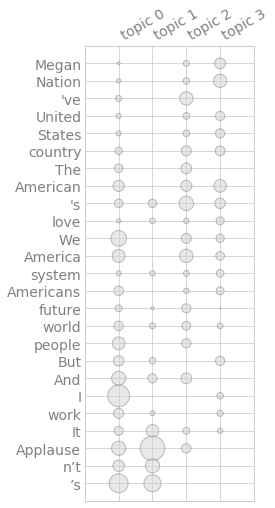

In [61]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,
                   topics=range(4),  n_terms=25, sort_terms_by='seriation')

## Clustering with PCA

It is now also possible to cluster the documents based in their tf-idf weihts using PCA.

In [62]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

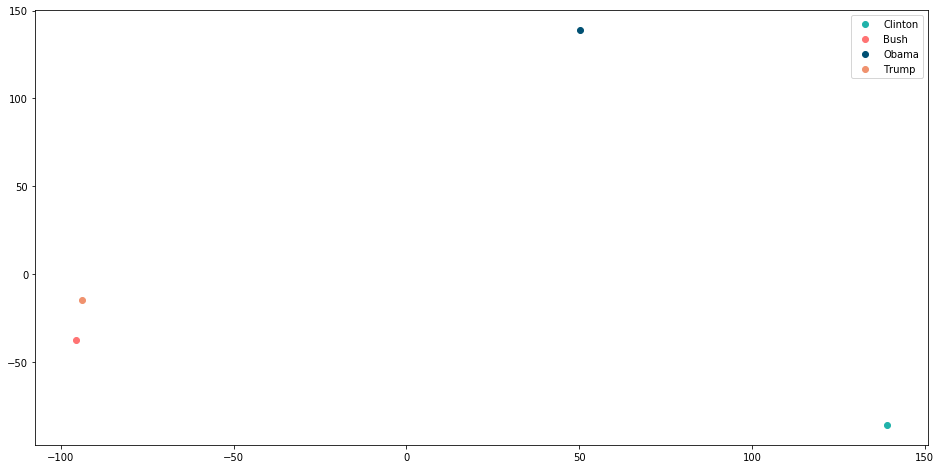

In [63]:
X = doc_term_matrix.todense()
labels_color_map = {
    'Clinton': '#20b2aa', 'Bush': '#ff7373', 'Obama': '#005073', 'Trump': '#F0926E'
}
labels = list(labels_color_map.keys())
reduced_data = PCA(n_components=2).fit_transform(X)

fig, ax = plt.subplots(figsize=(16, 8))
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
ax.legend(labels);

# Readability indices

Readability indices are ways of assessing how easy or complex it is to read a particular text based on the words and sentences it has. They usually output scores that correlate with grade levels.

A couple of indices that are presumably easy to calculate are the [Auto Readability Index (ARI)](https://en.wikipedia.org/wiki/Automated_readability_index) and the [Coleman-Liau Index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index):

$$
ARI = 4.71\frac{chars}{words}+0.5\frac{words}{sentences}-21.43
$$
$$ CL = 0.0588\frac{letters}{100 words} - 0.296\frac{sentences}{100words} - 15.8 $$


In [64]:
# problem: the tokens in spacy include punctuation. to get this right, we should remove punct
# we then have to make sure our functions handle lists of words rather than spacy doc objects

def coleman_liau_index(doc, words):
    return (0.0588 * letters_per_100(doc)) - (0.296 * sentences_per_100(doc, words)) - 15.8

def count_chars(words):
    return sum(len(w) for w in words)

def sentences_per_100(doc, words):
    return (len(list(doc.sents)) / len(words)) * 100

def letters_per_100(words):
    return (count_chars(words) / len(words)) * 100

In [65]:
# To get just the words, without punctuation tokens
def return_words(doc):
    return [token.text for token in doc if token.pos_ is not 'PUNCT']

In [66]:
fancy_doc = nlp("Regional ontology, clearly defined by Heidegger, equals, if not surpasses, the earlier work of Heidegger's own mentor, Husserl")
fancy_words = return_words(fancy_doc)
fancy_words

['Regional',
 'ontology',
 'clearly',
 'defined',
 'by',
 'Heidegger',
 'equals',
 'if',
 'not',
 'surpasses',
 'the',
 'earlier',
 'work',
 'of',
 'Heidegger',
 "'s",
 'own',
 'mentor',
 'Husserl']

In [67]:
coleman_liau_index(fancy_doc, fancy_words)

9.347105263157896

In [68]:
doc = nlp(clinton_speech)
clinton_speech_words = return_words(doc)
coleman_liau_index(doc, clinton_speech_words)

6.646373434685

<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;">
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Activity
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
Write a function `auto_readability_index(doc)` that receives a spacy `Doc` and returns the Auto Readability Index (ARI) score as defined above. 
<br/>
* **Hint**: Feel free to use functions we've defined before.*
   
</p>
</div>

In [69]:
def auto_readability_index(doc):
    words = return_words(doc)
    chars = count_chars(words)
    words = len(words)
    sentences = len(list(doc.sents))
    return (4.71 * (chars / words)) + (0.5 * (words / sentences)) - 21.43

In [70]:
auto_readability_index(fancy_doc)

13.851052631578945

In [71]:
auto_readability_index(doc)

8.638762457365601

In [72]:
clinton_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/clinton2000.txt"
bush_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/bush2008.txt"
obama_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/obama2016.txt"
trump_url = "https://raw.githubusercontent.com/sul-cidr/python_workshops/master/data/trump.txt"

In [73]:
clinton_speech = get_speech(clinton_url)
bush_speech = get_speech(bush_url)
obama_speech = get_speech(obama_url)
trump_speech = get_speech(trump_url)

In [74]:
speeches = {
    "clinton": nlp(clinton_speech),
    "bush": nlp(bush_speech),
    "obama": nlp(obama_speech),
    "trump": nlp(trump_speech),
}

In [75]:
print("Name", "Chars", "Words", "Unique", "Sentences", sep="\t")
for speaker, speech in speeches.items():
    words = return_words(speech)
    print(speaker, count_chars(words), len(words), len(set(words)), len(list(speech.sents)), sep="\t")

Name	Chars	Words	Unique	Sentences
clinton	42109	9400	2048	524
bush	27370	5852	1673	316
obama	27948	6383	1665	450
trump	22382	4819	1532	261


<div style="font-size: 1em; margin: 1em 0 1em 0; border: 1px solid #86989B; background-color: #f7f7f7; padding: 0;">
<p style="margin: 0; padding: 0.1em 0 0.1em 0.5em; color: white; border-bottom: 1px solid #86989B; font-weight: bold; background-color: #AFC1C4;">
Activity
</p>
<p style="margin: 0.5em 1em 0.5em 1em; padding: 0;">
Write a function `avg_sentence_length(blob)` that receives a spaCy `doc` and returns the average number of words in a sentence for the doc. You might need to use our `return_words` function.
</p>
</div>

In [76]:
# average sentence length
def avg_sentence_length(doc):
    return sum(len(return_words(s)) for s in doc.sents) / len(list(doc.sents))

In [77]:
for speaker, speech in speeches.items():
    print(speaker, avg_sentence_length(speech))

clinton 17.938931297709924
bush 18.518987341772153
obama 14.184444444444445
trump 18.46360153256705


We might stop to ask why Obama's speech seems to have shorter sentences. Is it deliberate rhetorical choice? Or could it be an issue with the data itself?

In this case, if we look closely at the txt file, we can see that the transcription of the speech included the world 'applause' as a one word sentence throughout the text. Let's see what happens if we filter that out. 

In [78]:
obama_clean_speech = obama_speech.replace("(Applause.)", "")

In [79]:
# Let's compare lengths of the texts. We should see a difference.

len(obama_speech), len(obama_clean_speech)

(35217, 34293)

In [80]:
# Now let's recheck the average sentence length of Obama's speech.
avg_sentence_length(nlp(obama_clean_speech))

17.03485254691689

In [81]:
speeches = {
    "clinton": nlp(clinton_speech),
    "bush": nlp(bush_speech),
    "obama": nlp(obama_clean_speech),
    "trump": nlp(trump_speech),
}

Let's write a quick function to get the most common words used by each person

In [82]:
def most_common_words(doc, n):
    words = return_words(doc)
    c = Counter(words)
    return c.most_common(n)

In [83]:
for speaker, speech in speeches.items():
    print(speaker, most_common_words(speech, 10))

clinton [('to', 399), ('the', 369), ('and', 265), ('of', 209), ('in', 186), ('our', 155), ('a', 146), ('I', 146), ('we', 142), (' ', 132)]
bush [('the', 278), ('and', 225), ('to', 183), ('of', 165), ('in', 117), ('our', 104), ('a', 104), ('we', 96), (' ', 70), ('that', 70)]
obama [('the', 274), ('to', 206), ('of', 149), ('and', 142), ('that', 130), ('we', 121), ('a', 117), (' ', 107), ('in', 99), ('our', 85)]
trump [('the', 215), ('and', 176), ('of', 142), ('to', 142), ('our', 101), ('a', 88), ('we', 72), ('in', 71), ('that', 61), ('is', 58)]


You can see quickly that we need to remove some of these most common words. To do this, we'll use common lists of stopwords.

In [85]:
from spacy.lang.en.stop_words import STOP_WORDS
print(list(STOP_WORDS)[:100])

['how', 'moreover', 'front', 'eight', 'whereby', 'its', 'is', 'see', 'very', 'wherever', 'has', 'there', 'anywhere', 'both', 'but', 'noone', 'become', 'becomes', 'else', 'take', 'top', 'whereafter', 'same', 'quite', 'regarding', 'before', 'i', 'though', 'throughout', 'elsewhere', 'until', 'whether', 'their', 'something', 'ever', 'three', 'whereupon', 'move', 'forty', 'whole', 'everywhere', 'some', 'already', 'neither', 'perhaps', 'from', 'many', 'often', 'therefore', 'could', 'whereas', 'across', 'thereafter', 'eleven', 'several', 'the', 'beyond', 'nobody', 'here', 'along', 'my', 'alone', 'former', 'last', 'somewhere', 'twelve', 'just', 'anyway', 'than', 'at', 'yourselves', 'by', 'were', 'therein', 'otherwise', 'whence', 'among', 'six', 'every', 'using', 'various', 'four', 'nor', 'out', 'your', 'except', 'back', 'put', 'down', 'if', 'serious', 'what', 'upon', 'yourself', 'have', 'all', 'really', 'seemed', 'ca', 'then']


In [86]:
# to make sure we've got all the punctuation out and to remove some contractions, we'll have a custom stoplist
custom_stopwords = [',', '-', '.', '’s', '-', ' ', '(', ')', '--', '---', 'n’t', ';', "'s", "'ve", "  ", "’ve"]

In [87]:
def most_common_words(doc, n):
    words = [token.text for token in doc if token.pos_ is not 'PUNCT' 
             and token.lower_ not in STOP_WORDS and token.text not in custom_stopwords]
    c = Counter(words)
    return c.most_common(n)

In [88]:
for speaker, speech in speeches.items():
    print(speaker, ": ", most_common_words(speech, 10), "\n")

clinton :  [('new', 46), ('ask', 43), ('people', 41), ('children', 38), ('years', 35), ('help', 35), ('America', 33), ('year', 29), ('work', 27), ('want', 27)] 

bush :  [('America', 34), ('people', 31), ('Congress', 27), ('year', 25), ('new', 24), ('Iraq', 22), ('American', 20), ('nation', 19), ('help', 18), ('trust', 17)] 

obama :  [('America', 33), ('people', 26), ('world', 23), ('work', 22), ('American', 22), ('want', 19), ('years', 18), ('change', 18), ('new', 18), ('year', 17)] 

trump :  [('American', 31), ('America', 30), ('new', 19), ('country', 18), ('people', 15), ('Americans', 15), ('Nation', 13), ('world', 13), ('United', 12), ('States', 12)] 



This sort of exploratory work is often the first step in figuring out how to clean a text for text analysis. 

Let's assess the lexical richness, defined as the ratio of number of unique words by the number of total words.

In [89]:
def lexical_richness(doc):
    words = return_words(doc)
    return len(set(words)) / len(words)

In [90]:
for speaker, speech in speeches.items():
    print(speaker, lexical_richness(speech))

clinton 0.2178723404255319
bush 0.28588516746411485
obama 0.2615675165250236
trump 0.31790827972608426


Let's look at the readbility scores for all four speeches now

For the Automated Readability Index, you can get the appropriate grade level here: https://en.wikipedia.org/wiki/Automated_readability_index

In [91]:
for speaker, speech in speeches.items():
    words = return_words(speech)
    print(speaker, "ARI:", auto_readability_index(speech), "CL:", coleman_liau_index(speech, words))

clinton ARI: 8.638762457365601 CL: 6.646373434685
bush ARI: 9.858321422082248 CL: 7.968139771744301
obama ARI: 7.3573271233168 CL: 5.580341615120549
trump ARI: 9.677546771678834 CL: 7.550412919791167


To get some comparison, let's also look at some stats calculated through Textacy. We'll see the ARI and CL scores, which use the same formulas we used. However, you might notice that the scores are different. To understand why, you have to dig into the source code for Textacy, where you'll find that it filters out punctuation in creating the word list, which affects the number of characters. It also lowercases the punctuation-filtered words before creating the set of unique words, decreasing that number as well compared to how we calculated it here. These changes affect both the ARI and CL scores.

In [92]:
# https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index
# https://en.wikipedia.org/wiki/Automated_readability_index
txt_speeches = [clinton_speech, bush_speech, obama_clean_speech, trump_speech]
corpus = textacy.Corpus('en', txt_speeches)
for doc in corpus:
    stats = textacy.text_stats.TextStats(doc)
    print({
        "ARI": stats.automated_readability_index,
        "CL": stats.coleman_liau_index,
        "stats": stats.basic_counts
    })

{'ARI': 8.746233720558635, 'CL': 9.157630474212347, 'stats': {'n_sents': 524, 'n_words': 9268, 'n_chars': 41977, 'n_syllables': 13125, 'n_unique_words': 1918, 'n_long_words': 1969, 'n_monosyllable_words': 6701, 'n_polysyllable_words': 961}}
{'ARI': 9.958682775745075, 'CL': 10.347694870264665, 'stats': {'n_sents': 316, 'n_words': 5781, 'n_chars': 27299, 'n_syllables': 8503, 'n_unique_words': 1585, 'n_long_words': 1420, 'n_monosyllable_words': 3967, 'n_polysyllable_words': 705}}
{'ARI': 7.495050682145184, 'CL': 8.131090335102964, 'stats': {'n_sents': 373, 'n_words': 6216, 'n_chars': 27177, 'n_syllables': 8615, 'n_unique_words': 1568, 'n_long_words': 1197, 'n_monosyllable_words': 4580, 'n_polysyllable_words': 604}}
{'ARI': 9.679193899314352, 'CL': 9.910002382523874, 'stats': {'n_sents': 261, 'n_words': 4818, 'n_chars': 22381, 'n_syllables': 6975, 'n_unique_words': 1425, 'n_long_words': 1138, 'n_monosyllable_words': 3340, 'n_polysyllable_words': 546}}


Why do we have such a significant difference in the CL scores? Let's look quickly at the textacy implementation: https://github.com/chartbeat-labs/textacy/blob/5927d539dd989c090f8a0b0c06ba40bb204fce82/textacy/text_stats.py#L277

In [93]:
print("Name", "Chars", "Words", "Unique", "Sentences", sep="\t")
for speaker, speech in speeches.items():
    words = return_words(speech)
    print(speaker, count_chars(words), len(words), len(set(words)), len(list(speech.sents)), sep="\t")


Name	Chars	Words	Unique	Sentences
clinton	42109	9400	2048	524
bush	27370	5852	1673	316
obama	27345	6354	1662	373
trump	22382	4819	1532	261


## Corpus level statistics

In [94]:
# clinton, bush, obama, trump
for doc in corpus:
    stats = textacy.text_stats.TextStats(doc)
    print({
        "stats": stats.basic_counts
    })

{'stats': {'n_sents': 524, 'n_words': 9268, 'n_chars': 41977, 'n_syllables': 13125, 'n_unique_words': 1918, 'n_long_words': 1969, 'n_monosyllable_words': 6701, 'n_polysyllable_words': 961}}
{'stats': {'n_sents': 316, 'n_words': 5781, 'n_chars': 27299, 'n_syllables': 8503, 'n_unique_words': 1585, 'n_long_words': 1420, 'n_monosyllable_words': 3967, 'n_polysyllable_words': 705}}
{'stats': {'n_sents': 373, 'n_words': 6216, 'n_chars': 27177, 'n_syllables': 8615, 'n_unique_words': 1568, 'n_long_words': 1197, 'n_monosyllable_words': 4580, 'n_polysyllable_words': 604}}
{'stats': {'n_sents': 261, 'n_words': 4818, 'n_chars': 22381, 'n_syllables': 6975, 'n_unique_words': 1425, 'n_long_words': 1138, 'n_monosyllable_words': 3340, 'n_polysyllable_words': 546}}
